<a href="https://colab.research.google.com/github/dtran556/dtran556/blob/main/artGenerator(real).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Foward Diffusion
Grab an image and then iteratively add more noise to the image until the image is fully noisy.

Backwards Diffusion
Grab an image and then iteratively reduce noise until the noisy image is pure.

Proof of concept using a DDPM Diffuser:
Cannot do backwards diffusion until the model is fully trained

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset
from torch.utils.data import DataLoader
maxSteps = 1000
noiseScheduler = DDPMScheduler(num_train_timesteps=maxSteps,
                               beta_start=0.001,
                               beta_end=0.02)

def load_img():
    image_path = "/content/Sloth-RF.jpg"
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    return transform(image).numpy()

def plot_images(timesteps, images, title="Images"):
    fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
    for i, (t, img) in enumerate(zip(timesteps, images)):
        img_display = np.transpose(img, (1, 2, 0))
        img_display = np.clip(img_display, 0, 1)
        axes[i].imshow(img_display)
        axes[i].set_title(f"t={t}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

image = torch.tensor(load_img())
forward_timesteps = torch.arange(0, maxSteps, maxSteps // 10)
print(f"Forward timesteps: {forward_timesteps}")

noise = torch.randn(image.shape)
noisyImage = noiseScheduler.add_noise(
    image.unsqueeze(0),
    noise.unsqueeze(0),
    forward_timesteps.unsqueeze(0)
).squeeze(0).numpy()

plot_images(forward_timesteps, noisyImage, "Forward Diffusion")

FileNotFoundError: [Errno 2] No such file or directory: '/content/Sloth-RF.jpg'

Import statements for the actual model:

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


Training the model based off of this data set of 130k random images
https://huggingface.co/datasets/opendiffusionai/pexels-photos-janpf

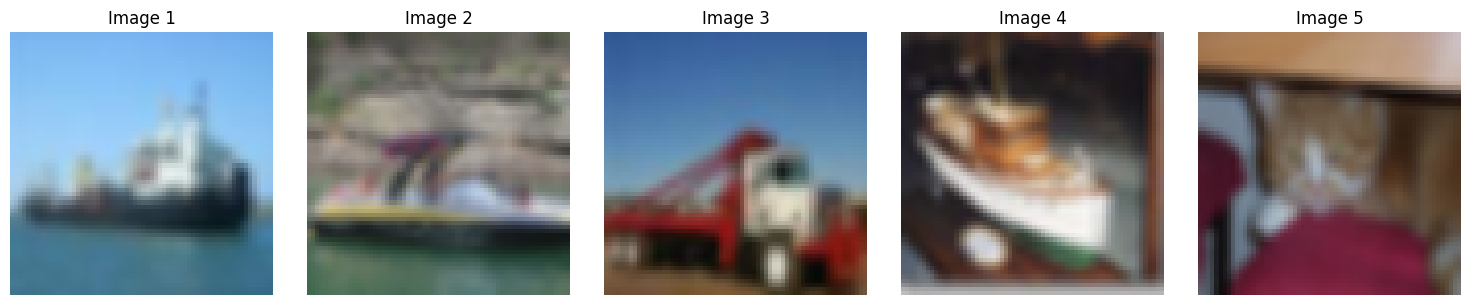

In [19]:
dataset = load_dataset("cifar10")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset['train']
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['img']

        if self.transform:
            image = self.transform(image)

        return image

cifar10_dataset = CIFAR10Dataset(dataset, transform=transform)
dataloader = DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, image in enumerate(dataloader):
    if i >= 5:
        break

    img_display = image.squeeze(0).numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)

    axes[i].imshow(img_display)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Training loop:


In [20]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.time_embed = nn.Linear(1, 256)

        self.upconv1 = nn.Conv2d(256, 128, 3, padding=1)

        self.upconv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.out = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x, timestep):
        # Downsampling
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Time embedding
        t_emb = self.time_embed(timestep.float().unsqueeze(-1))
        t_emb = t_emb.view(-1, 256, 1, 1)
        x = x + t_emb

        # Upsampling
        x = torch.relu(self.upconv1(x))
        x = torch.relu(self.upconv2(x))
        x = self.out(x)

        return x

In [21]:
maxSteps = 1000
noiseScheduler = DDPMScheduler(num_train_timesteps=maxSteps,
                               beta_start=0.001,
                               beta_end=0.02)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")



unet_model = SimpleUNet().to(device)
optimizer = Adam(unet_model.parameters(), lr=1e-4)


max_timesteps = 1000
num_epochs = 25
batch_size = 128

print("Starting training...")
print(f"Model parameters: {sum(p.numel() for p in unet_model.parameters()):,}")

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    for batch_idx, images in enumerate(dataloader):
        # Load Data
        images = images.to(device)
        img_shape = images.shape  # [Batch Size, Num Channels, W, H]

        # Run augmentations (simple random horizontal flip)
        if torch.rand(1) > 0.5:
            images = torch.flip(images, dims=[3])

        # Forward Diffusion
        # Generate Random Noise for Random timesteps
        timesteps = torch.randint(0, max_timesteps, (len(images),)).to(device)
        noise = torch.randn(img_shape).to(device)

        # Add noise to images
        noisy_images = noiseScheduler.add_noise(images, noise, timesteps)

        # UNet Forward Pass
        prediction = unet_model(noisy_images, timesteps)

        # Calculate Loss
        loss = F.mse_loss(prediction, noise)

        # Update Weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("Training completed!")
torch.save(unet_model.state_dict(), 'genImage25epoch.pth')
torch.save({
    'model_state_dict': unet_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': avg_loss
},'trained_unet_path.pth')

print("Model Saved")

Using device: cuda
GPU: NVIDIA L4
GPU Memory: 23.8 GB
Starting training...
Model parameters: 741,891
Epoch 1 completed. Average Loss: 0.1260
Epoch 2 completed. Average Loss: 0.0181
Epoch 3 completed. Average Loss: 0.0150
Epoch 4 completed. Average Loss: 0.0132
Epoch 5 completed. Average Loss: 0.0122
Epoch 6 completed. Average Loss: 0.0115
Epoch 7 completed. Average Loss: 0.0108
Epoch 8 completed. Average Loss: 0.0103
Epoch 9 completed. Average Loss: 0.0099
Epoch 10 completed. Average Loss: 0.0097
Epoch 11 completed. Average Loss: 0.0094
Epoch 12 completed. Average Loss: 0.0093
Epoch 13 completed. Average Loss: 0.0088
Epoch 14 completed. Average Loss: 0.0087
Epoch 15 completed. Average Loss: 0.0086
Epoch 16 completed. Average Loss: 0.0085
Epoch 17 completed. Average Loss: 0.0084
Epoch 18 completed. Average Loss: 0.0082
Epoch 19 completed. Average Loss: 0.0081
Epoch 20 completed. Average Loss: 0.0080
Epoch 21 completed. Average Loss: 0.0080
Epoch 22 completed. Average Loss: 0.0079
Epoch 

Testing models ability to generate images of decent quality

LOADING MODEL

In [23]:
unet_model = SimpleUNet().to(device)
unet_model.load_state_dict(torch.load('genImage25epoch.pth'))
unet_model.eval()

SimpleUNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_embed): Linear(in_features=1, out_features=256, bias=True)
  (upconv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

(5, 3, 64, 64)


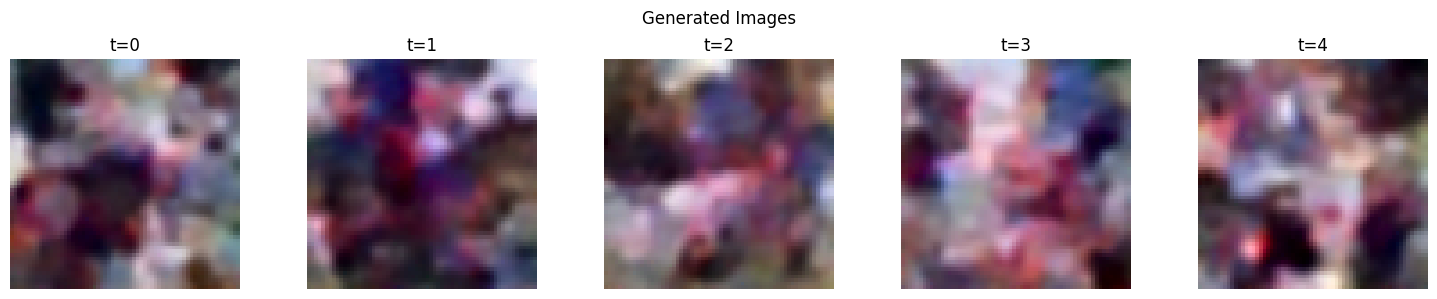

In [32]:
maxSteps = 1000
noiseScheduler = DDPMScheduler(num_train_timesteps=maxSteps,
                               beta_start=0.001,
                               beta_end=0.02)
def genImage(model,num_images = 5):
  model.eval()
  with torch.no_grad():
    noise = torch.rand(num_images, 3, 64, 64).to(device)
    for i in reversed(range(max_timesteps)):
      timestep = torch.full((num_images,), i, device = device)
      predicted_noise = model(noise, timestep)
      noise = noiseScheduler.step(predicted_noise, i, noise).prev_sample
    return noise.cpu().numpy()
def plot_images(timesteps, images, title="Images"):
    fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
    for i, (t, img) in enumerate(zip(timesteps, images)):
        img_display = np.transpose(img, (1, 2, 0))
        img_display = np.clip(img_display, 0, 1)
        axes[i].imshow(img_display)
        axes[i].set_title(f"t={t}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
generated = genImage(unet_model, 5)
print(generated.shape)
plot_images(range(5), generated, "Generated Images")